In [20]:
pip install langgraph langsmith langchain langchain_groq langchain_community

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install arxiv wikipedia

Note: you may need to restart the kernel to use updated packages.


In [22]:
from typing import Annotated
from typing_extensions import TypedDict

In [23]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=500)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [24]:
wiki_tool.invoke("who is America")

'Page: Who Is America?\nSummary: Who Is America? is an American political satire mockumentary-style television series created by Sacha Baron Cohen that premiered on July 15, 2018, on Showtime. Baron Cohen also stars in the series as various characters and executive produces alongside Anthony Hines, Todd Schulman, Andrew Newman, Dan Mazer, and Adam Lowitt.\n\n'

In [25]:
arxiv_tool.invoke("RAG MODELS")

'Published: 2024-07-26\nTitle: Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks\nAuthors: Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang\nSummary: Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which'

In [26]:
tools=[arxiv_tool]

In [27]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [28]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq

graph_builder= StateGraph(State)
groq_api_key = "xxx"
llm= ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It", temperature=0)
llm_with_tools=llm.bind_tools(tools=tools)

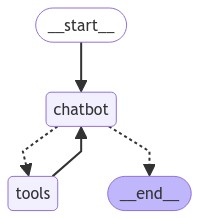

In [29]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

from langgraph.prebuilt import ToolNode,tools_condition

graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")

graph=graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
user_input="Details regarding Computer Vision"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Details regarding Computer Vision
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_2453)
 Call ID: call_2453
  Args:
    query: Computer Vision
================================= Tool Message =================================
Name: arxiv

Published: 2019-05-20
Title: Implications of Computer Vision Driven Assistive Technologies Towards Individuals with Visual Impairment
Authors: Linda Wang, Alexander Wong
Summary: Computer vision based technology is becoming ubiquitous in society. One
application area that has seen an increase in computer vision is assistive
technologies, specifically for those with visual impairment. Research has shown
the ability of computer vision models to achieve tasks such provide scene
captions, detect obj
================================== Ai Message ==================================

Computer vision is a field of artificia

In [31]:
user_input = "what is RNN."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RNN.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_v22q)
 Call ID: call_v22q
  Args:
    query: Recurrent Neural Networks
================================= Tool Message =================================
Name: arxiv

Published: 2020-10-20
Title: Implicit recurrent networks: A novel approach to stationary input processing with recurrent neural networks in deep learning
Authors: Sebastian Sanokowski
Summary: The brain cortex, which processes visual, auditory and sensory data in the
brain, is known to have many recurrent connections within its layers and from
higher to lower layers. But, in the case of machine learning with neural
networks, it is generally assumed that strict feed-forward architectures are
suit
================================== Ai Message ==================================

RNN stands for Recurrent Neural Network. 

It's a 